In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 

import warnings
warnings.filterwarnings("ignore")

import calendar


# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from scipy import stats


from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


pd.options.display.float_format = "{:,.2f}".format 

# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations


from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Para la codificación de las variables numéricas
# -----------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder#, TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 

sys.path.append(os.path.abspath("../../src"))   
import soporte_preprocesamiento as f
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder     #solo me deja hacerlo si uso el entorno default en vez del proyecto
pd.set_option("display.max_columns", None)


In [2]:
df_sinout=pd.read_csv("../../datos/datos2/datos_sin_outliers_iterativo.csv", index_col=0).reset_index(drop=True)


In [3]:
df_sinout["rooms"]=df_sinout["rooms"].astype("O")
df_sinout["bathrooms"]=df_sinout["bathrooms"].astype("O")
df_sinout["exterior"]=df_sinout["exterior"].astype("O")

In [4]:
df_sinout.head(2)

,price,propertyType,exterior,rooms,bathrooms,municipality,status,floor,hasLift,size_MinMax,distance_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,750.00,flat,True,1,1,Madrid,good,3,True,0.43,0.12,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,750.00,flat,True,2,1,San Sebastián de los Reyes,good,bj,False,0.53,0.28,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [5]:
df_sinout.duplicated().sum()

np.int64(1)

In [6]:
df_sinout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   337 non-null    float64
 1   propertyType            337 non-null    object 
 2   exterior                337 non-null    object 
 3   rooms                   337 non-null    object 
 4   bathrooms               337 non-null    object 
 5   municipality            337 non-null    object 
 6   status                  337 non-null    object 
 7   floor                   337 non-null    object 
 8   hasLift                 337 non-null    object 
 9   size_MinMax             337 non-null    float64
 10  distance_MinMax         337 non-null    float64
 11  outliers_ifo_0.01_100   337 non-null    float64
 12  outliers_ifo_0.01_400   337 non-null    float64
 13  outliers_ifo_0.01_1000  337 non-null    float64
 14  outliers_ifo_0.01_2000  337 non-null    fl

In [7]:
df_sinout_copy=df_sinout.copy()

Se ha comprobado usando value_counts que las columnas con las que contamos tiene sentido mantenerlas pues no domina una categoría frente a la otra de manera exagerada (Es decir que no nos vaya a aportar información relevante)

In [8]:
df_categoricas= df_sinout_copy.select_dtypes("O")

Tenemos 8 columnas de categóricas

In [9]:
df_categoricas.nunique()

propertyType     6
exterior         2
rooms            5
bathrooms        3
municipality    56
status           4
floor           14
hasLift          3
dtype: int64

In [10]:
df_categoricas.head()

,propertyType,exterior,rooms,bathrooms,municipality,status,floor,hasLift
0,flat,True,1,1,Madrid,good,3,True
1,flat,True,2,1,San Sebastián de los Reyes,good,bj,False
2,studio,True,0,1,Madrid,desconocido,desconocido,desconocido
3,flat,True,2,1,Manzanares el Real,good,3,False
4,duplex,True,1,1,Miraflores de la Sierra,good,1,False


Vamos a recordar la distribución de la categóricas

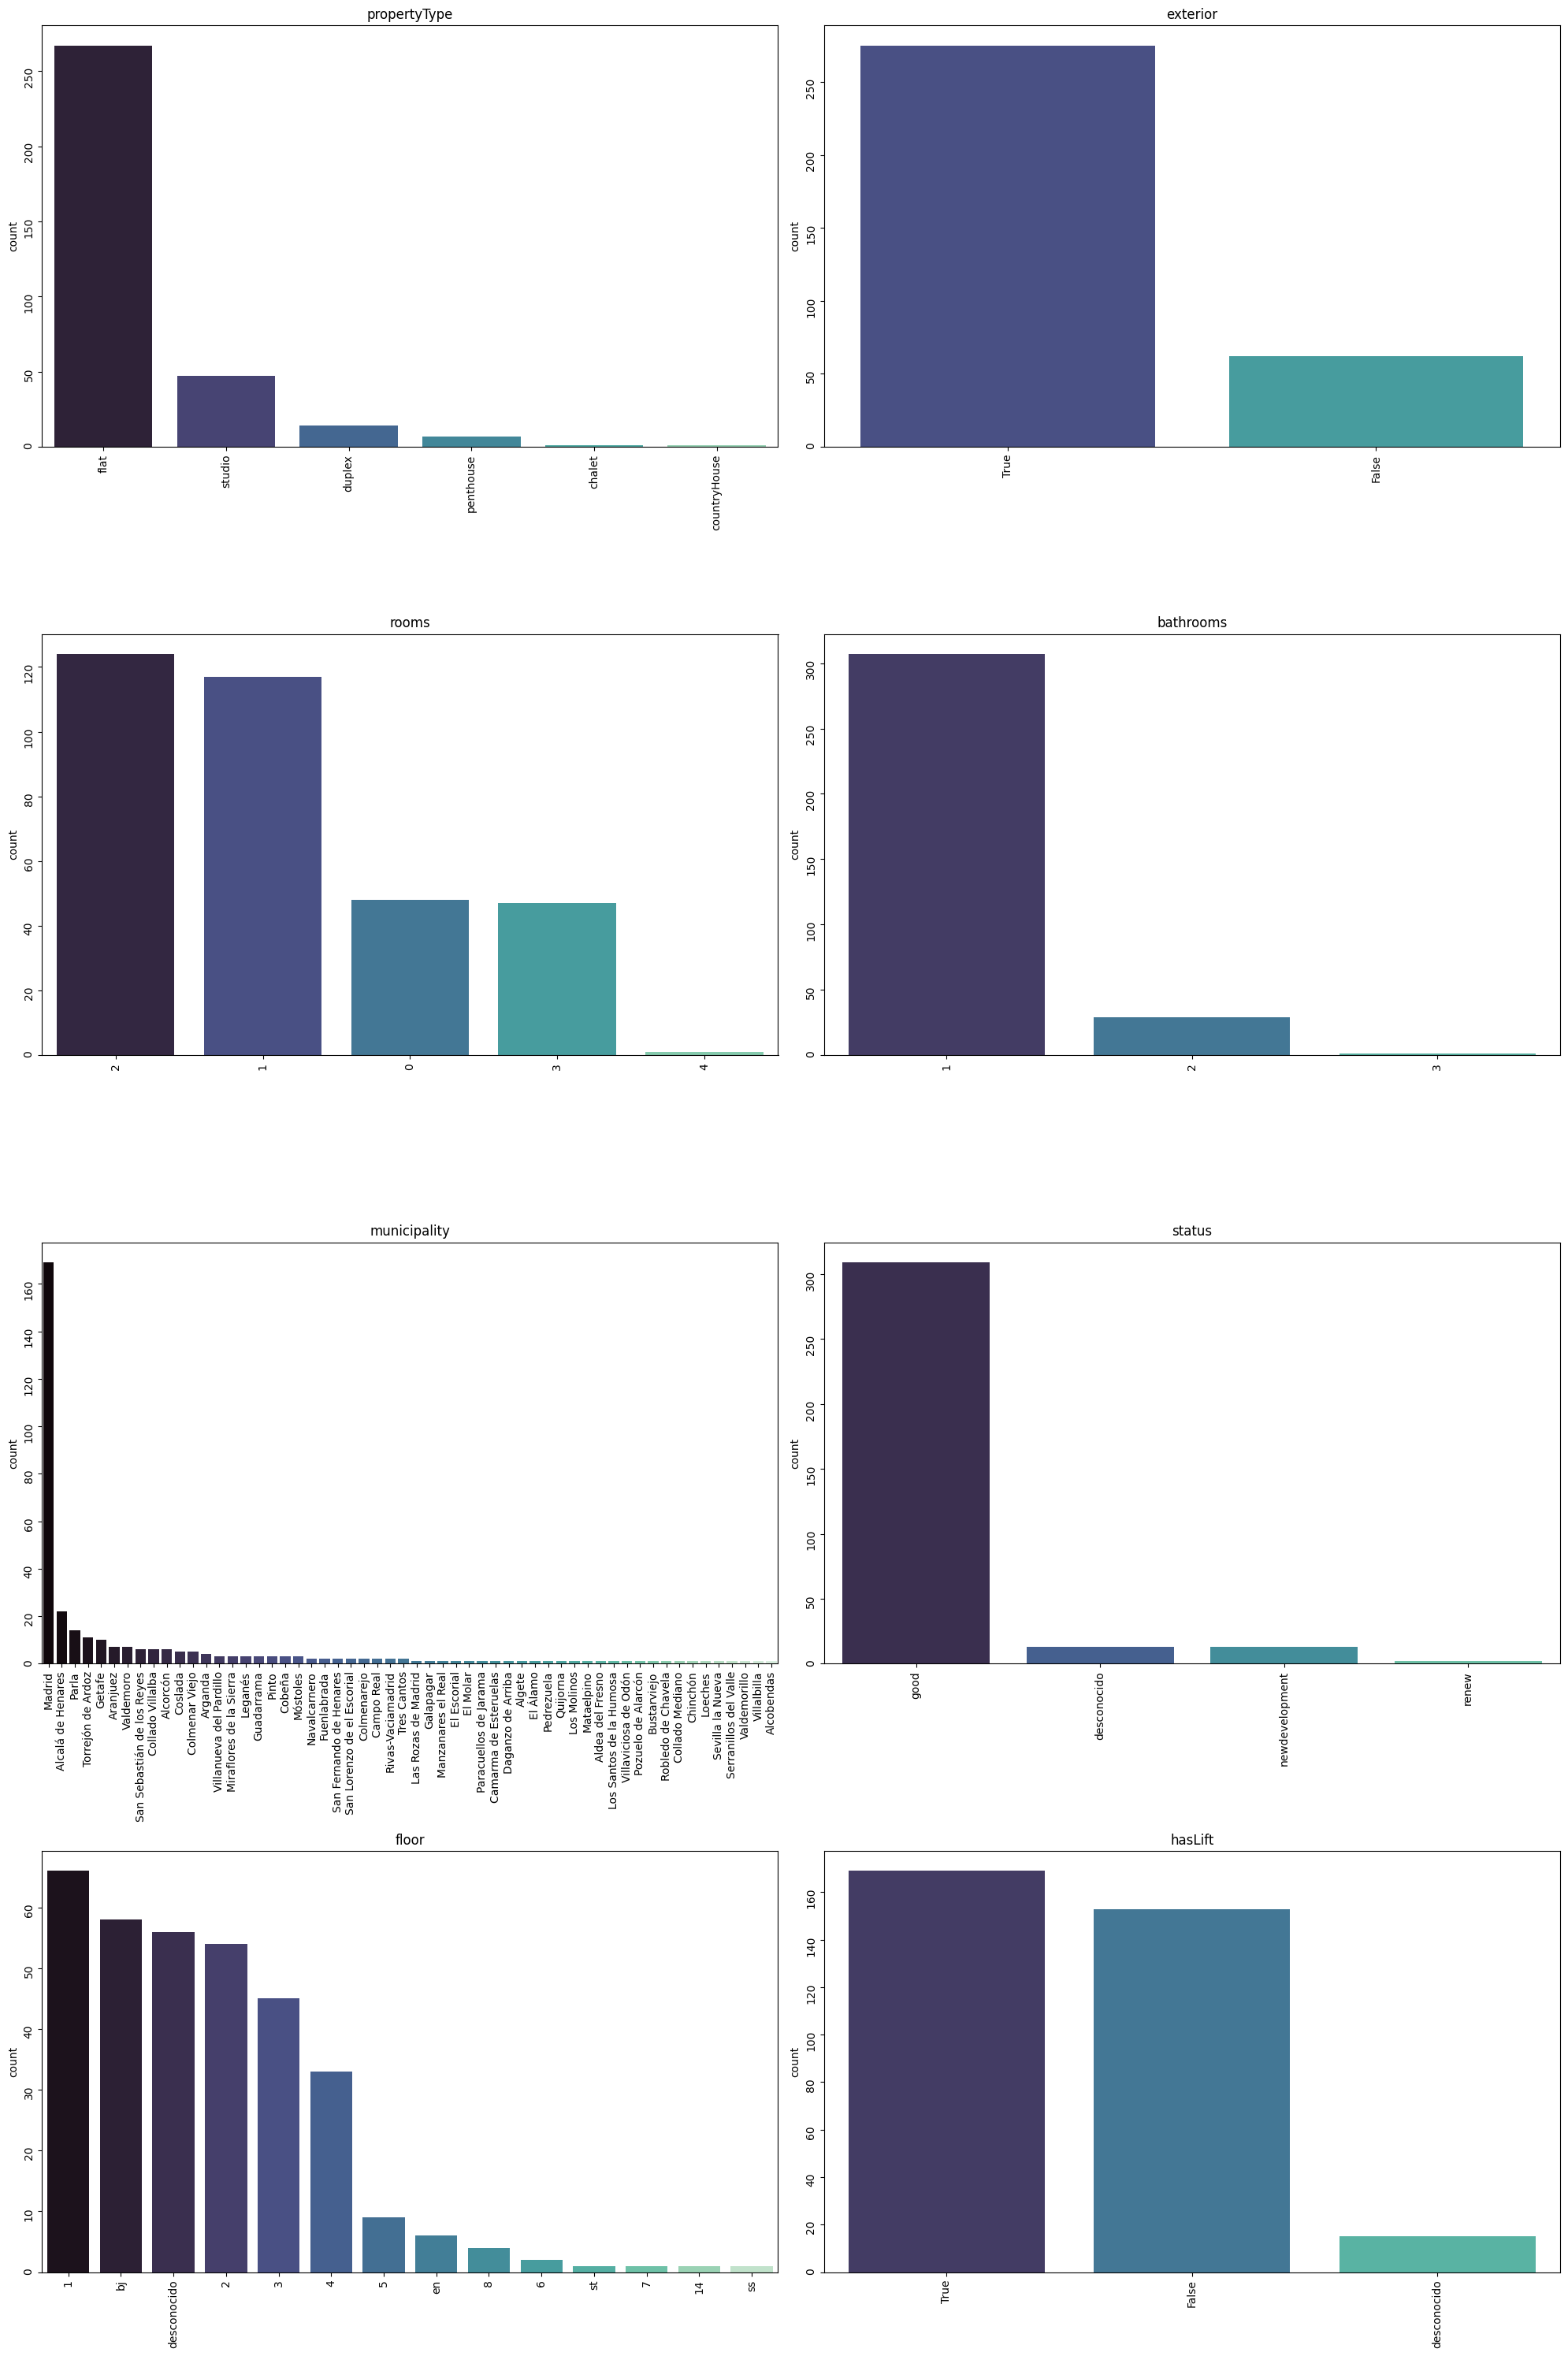

In [11]:
f.plot_categoricas(df_categoricas, (20,30))

Ahora vamos a visualizar la relación entre la dependiente y las categóricas 

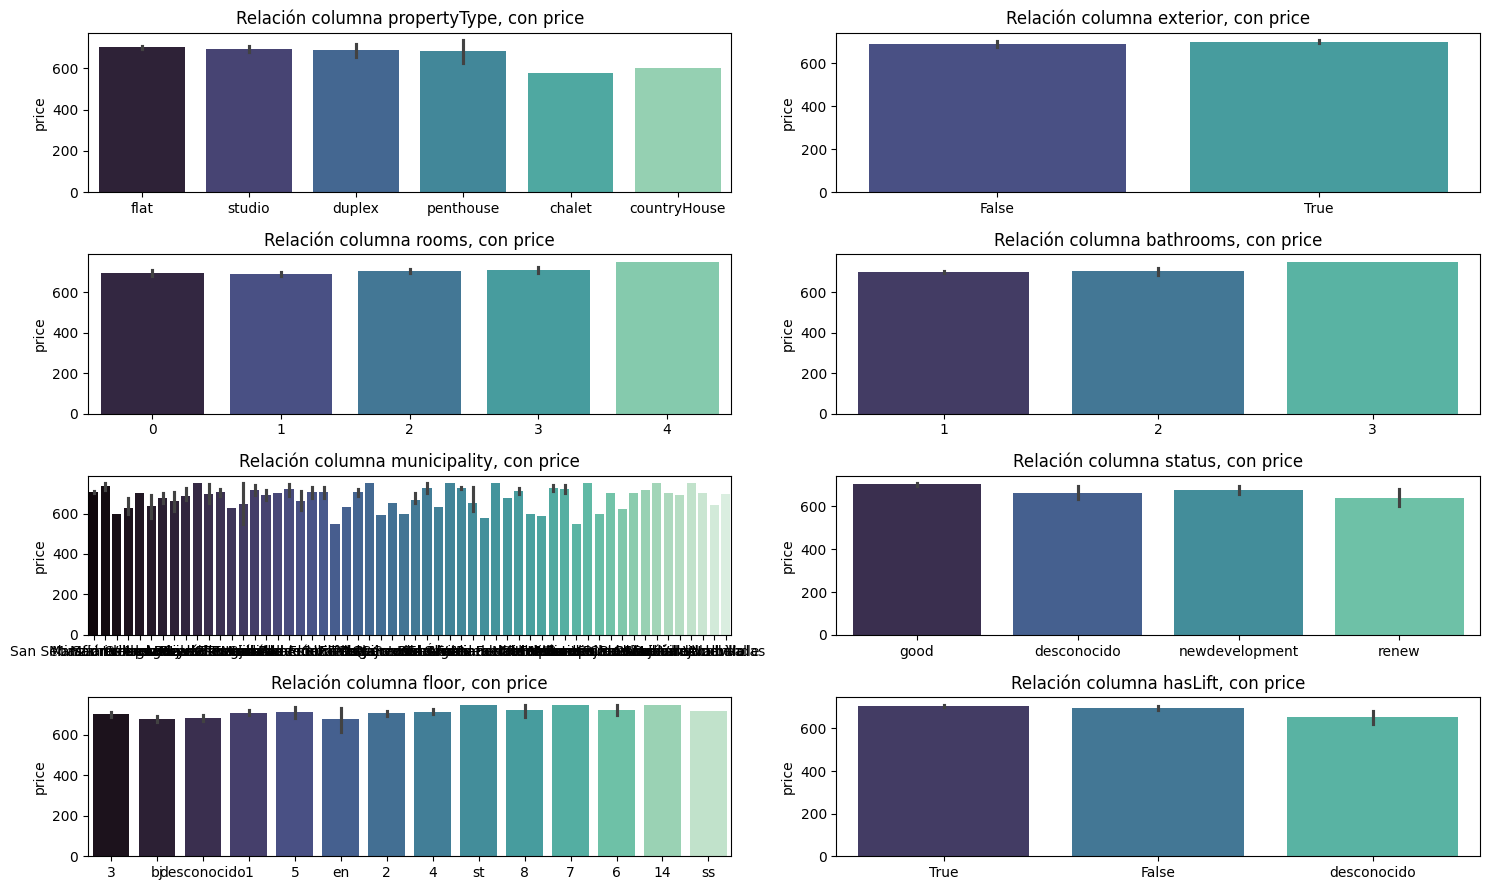

In [12]:
f.visualizar_categoricas(df_sinout_copy, "price", (15,9), "bar")

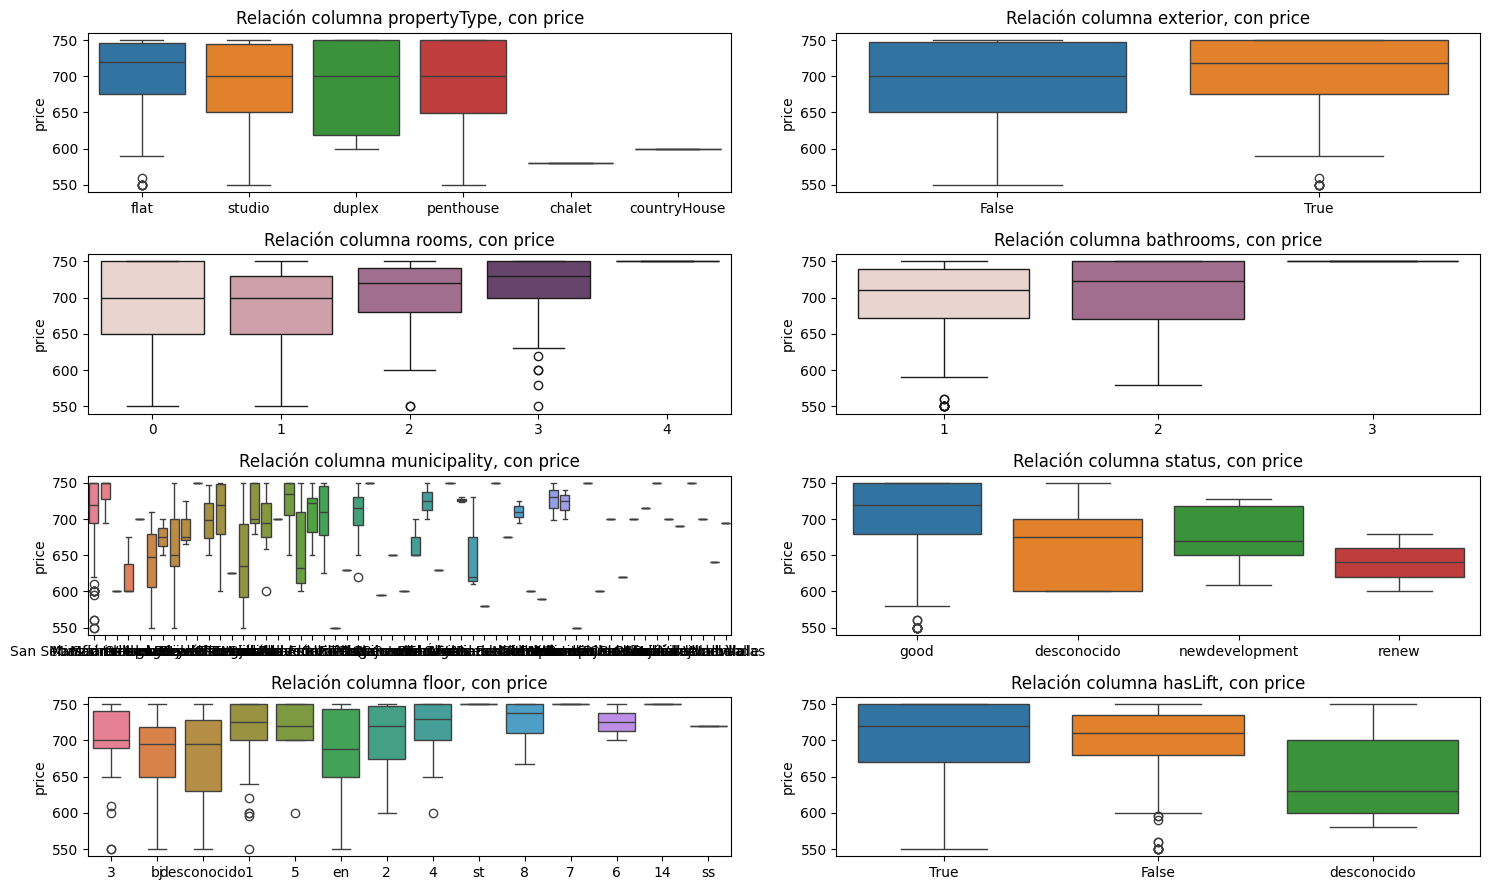

In [13]:
f.visualizar_categoricas(df_sinout_copy, "price", (15,9), "box")

Ahora debemos comprobar la normalidad y homocedasticidad para saber si son parametricas o no parametricas (Con el fin de más adelante poder evaluar si hay diferencias significativas)

Estamos probando primero con kruskal para en aquellas que solo tienen dos categoría comparar con Whitney

Tuve que convertir estas variables a str porque sino no las detectaba como categóricas

In [14]:
df_sinout_copy["exterior"]=df_sinout_copy["exterior"].astype(str)
df_sinout_copy["rooms"]=df_sinout_copy["rooms"].astype(str)
df_sinout_copy["bathrooms"]=df_sinout_copy["bathrooms"].astype(str)

In [15]:
# llamamos a la clase de Asunciones, para poder decir qué método usar para el análisis estadístico
asunciones = f.Asunciones(dataframe = df_sinout_copy, columna_numerica= "price")
print("\n-------------\n")
lista_col_categ=df_sinout_copy.select_dtypes(include="O")

for categoria in lista_col_categ:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # llamamos la clase de test estadísticos para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = f.TestEstadisticos(df_sinout_copy, "price", categoria)
    test.run_all_tests()
    print("\n###########################\n")


-------------

Estamos analizando la variable PROPERTYTYPE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable propertyType las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['flat', 'studio', 'duplex', 'penthouse', 'chalet', 'countryHouse']



Realizando test de Kruskal...
Estadístico de prueba: 5.70694411763261
Valor p: 0.33578668458420236
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,20.00,1.00,-186.65,226.65,chalet-countryHouse
1,109.29,0.31,-41.97,260.54,chalet-duplex
2,121.74,0.17,-24.66,268.14,chalet-flat
3,105.57,0.38,-50.64,261.79,chalet-penthouse
4,113.66,0.24,-34.01,261.33,chalet-studio
5,89.29,0.54,-61.97,240.54,countryHouse-duplex
6,101.74,0.35,-44.66,248.14,countryHouse-flat
7,85.57,0.62,-70.64,241.79,countryHouse-penthouse
8,93.66,0.46,-54.01,241.33,countryHouse-studio
9,12.45,0.95,-27.61,52.52,duplex-flat



###########################

Estamos analizando la variable EXTERIOR
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable exterior las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False']

Realizando test de Kruskal...
Estadístico de prueba: 1.3100298443103129
Valor p: 0.2523892519566959
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,11.74,0.10,-2.46,25.94,False-True



###########################

Estamos analizando la variable ROOMS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable rooms las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['1', '2', '0', '3', '4']

Realizando test de Kruskal...
Estadístico de prueba: 10.267503048363363
Valor p: 0.03615482139786809
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-5.29,0.97,-29.29,18.70,0-1
1,9.72,0.80,-14.07,33.52,0-2
2,16.91,0.49,-11.81,45.64,0-3
3,55.17,0.82,-86.26,196.59,0-4
4,15.02,0.15,-3.02,33.06,1-2
5,22.21,0.09,-1.97,46.38,1-3
6,60.46,0.76,-80.11,201.04,1-4
7,7.19,0.92,-16.79,31.17,2-3
8,45.44,0.90,-95.10,185.98,2-4
9,38.26,0.95,-103.20,179.71,3-4



###########################

Estamos analizando la variable BATHROOMS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable bathrooms las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['1', '2', '3']

Realizando test de Kruskal...
Estadístico de prueba: 2.3652071605346907
Valor p: 0.30647975430194707
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,5.53,0.85,-18.03,29.10,1-2
1,51.53,0.58,-69.96,173.03,1-3
2,46.00,0.65,-77.37,169.37,2-3



###########################

Estamos analizando la variable MUNICIPALITY
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable municipality las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Madrid', 'San Sebastián de los Reyes', 'Manzanares el Real', 'Miraflores de la Sierra', 'Galapagar', 'Arganda', 'San Lorenzo de el Escorial', 'Aranjuez', 'Villanueva del Pardillo', 'Las Rozas de Madrid', 'Navalcarnero', 'Alcalá de Henares', 'El Escorial', 'Leganés', 'Coslada', 'Torrejón de Ardoz', 'Camarma de Esteruelas', 'Alcorcón', 'Valdemoro', 'Collado Villalba', 'Getafe', 'Paracuellos de Jarama', 'El Molar', 'Parla', 'Tres Cantos', 'Quijorna', 'Pedrezuela', 'Daganzo de Arriba', 'Guadarrama', 'Cobeña', 'El Álamo', 'Algete', 'Rivas-Vaciamadrid', 'Pinto', 'Los Santos de la Humosa', 'San Fernando de Henares', 'Aldea del Fresno', 'Fuenlabrada', 'Mataelpino', 'Los Molinos', 'Colmenar Viejo', 'Móstoles', 

,meandiff,p-adj,lower,upper,group_diff
0,-10.09,1.00,-204.71,184.53,Alcalá de Henares-Alcobendas
1,14.91,1.00,-72.76,102.57,Alcalá de Henares-Alcorcón
2,-30.09,1.00,-224.71,164.53,Alcalá de Henares-Aldea del Fresno
3,44.91,1.00,-149.71,239.53,Alcalá de Henares-Algete
4,-45.09,0.99,-127.69,37.51,Alcalá de Henares-Aranjuez
...,...,...,...,...,...
1535,27.67,1.00,-103.68,159.01,Valdemoro-Villanueva del Pardillo
1536,-61.00,1.00,-264.48,142.48,Valdemoro-Villaviciosa de Odón
1537,48.67,1.00,-171.12,268.45,Villalbilla-Villanueva del Pardillo
1538,-40.00,1.00,-309.18,229.18,Villalbilla-Villaviciosa de Odón



###########################

Estamos analizando la variable STATUS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable status las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['good', 'desconocido', 'newdevelopment', 'renew']

Realizando test de Kruskal...
Estadístico de prueba: 13.924292727296685
Valor p: 0.003010035576303598
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,39.36,0.03,2.28,76.43,desconocido-good
1,13.69,0.90,-37.67,65.05,desconocido-newdevelopment
2,-22.62,0.94,-122.08,76.85,desconocido-renew
3,-25.66,0.28,-62.74,11.41,good-newdevelopment
4,-61.97,0.31,-154.86,30.92,good-renew
5,-36.31,0.78,-135.77,63.15,newdevelopment-renew



###########################

Estamos analizando la variable FLOOR
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable floor las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['3', 'bj', 'desconocido', '1', '5', 'en', '2', '4', 'st', '8', '7', '6', '14', 'ss']

Realizando test de Kruskal...
Estadístico de prueba: 30.002605883568528
Valor p: 0.004705634609311262
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,39.35,1.00,-131.44,210.14,1-14
1,-4.89,1.00,-36.00,26.21,1-2
2,-8.70,1.00,-41.47,24.07,1-3
3,4.95,1.00,-31.19,41.09,1-4
4,3.79,1.00,-56.44,64.03,1-5
...,...,...,...,...,...
86,37.55,1.00,-133.47,208.57,desconocido-ss
87,67.55,0.99,-103.47,238.57,desconocido-st
88,40.83,1.00,-142.26,223.93,en-ss
89,70.83,0.99,-112.26,253.93,en-st



###########################

Estamos analizando la variable HASLIFT
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable hasLift las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False', 'desconocido']

Realizando test de Kruskal...
Estadístico de prueba: 11.068780044588683
Valor p: 0.003948616469565202
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,9.36,0.22,-3.89,22.61,False-True
1,-43.40,0.00,-75.52,-11.28,False-desconocido
2,-52.76,0.00,-84.75,-20.77,True-desconocido



###########################



Ahora con Mann-Whitney

In [16]:
# instanciamos la clase de Asunciones, para poder decir qué método usar para el análisis estadístico
asunciones = f.Asunciones(dataframe = df_sinout_copy, columna_numerica= "price")
print("\n-------------\n")
lista_col_categ=df_sinout_copy.select_dtypes(include="O")

for categoria in lista_col_categ:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = f.TestEstadisticos(df_sinout_copy, "price", categoria)
    test.run_all_tests()
    print("\n###########################\n")


-------------

Estamos analizando la variable PROPERTYTYPE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable propertyType las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['flat', 'studio', 'duplex', 'penthouse', 'chalet', 'countryHouse']



Realizando test de Kruskal...
Estadístico de prueba: 5.70694411763261
Valor p: 0.33578668458420236
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,20.00,1.00,-186.65,226.65,chalet-countryHouse
1,109.29,0.31,-41.97,260.54,chalet-duplex
2,121.74,0.17,-24.66,268.14,chalet-flat
3,105.57,0.38,-50.64,261.79,chalet-penthouse
4,113.66,0.24,-34.01,261.33,chalet-studio
5,89.29,0.54,-61.97,240.54,countryHouse-duplex
6,101.74,0.35,-44.66,248.14,countryHouse-flat
7,85.57,0.62,-70.64,241.79,countryHouse-penthouse
8,93.66,0.46,-54.01,241.33,countryHouse-studio
9,12.45,0.95,-27.61,52.52,duplex-flat



###########################

Estamos analizando la variable EXTERIOR
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable exterior las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False']

Realizando test de Mannwhitneyu...
Estadístico del Test de Mann-Whitney U: 9310.5
Valor p: 0.2526913279098736
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,11.74,0.10,-2.46,25.94,False-True



###########################

Estamos analizando la variable ROOMS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable rooms las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['1', '2', '0', '3', '4']

Realizando test de Kruskal...
Estadístico de prueba: 10.267503048363363
Valor p: 0.03615482139786809
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-5.29,0.97,-29.29,18.70,0-1
1,9.72,0.80,-14.07,33.52,0-2
2,16.91,0.49,-11.81,45.64,0-3
3,55.17,0.82,-86.26,196.59,0-4
4,15.02,0.15,-3.02,33.06,1-2
5,22.21,0.09,-1.97,46.38,1-3
6,60.46,0.76,-80.11,201.04,1-4
7,7.19,0.92,-16.79,31.17,2-3
8,45.44,0.90,-95.10,185.98,2-4
9,38.26,0.95,-103.20,179.71,3-4



###########################

Estamos analizando la variable BATHROOMS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable bathrooms las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['1', '2', '3']

Realizando test de Kruskal...
Estadístico de prueba: 2.3652071605346907
Valor p: 0.30647975430194707
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,5.53,0.85,-18.03,29.10,1-2
1,51.53,0.58,-69.96,173.03,1-3
2,46.00,0.65,-77.37,169.37,2-3



###########################

Estamos analizando la variable MUNICIPALITY
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable municipality las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Madrid', 'San Sebastián de los Reyes', 'Manzanares el Real', 'Miraflores de la Sierra', 'Galapagar', 'Arganda', 'San Lorenzo de el Escorial', 'Aranjuez', 'Villanueva del Pardillo', 'Las Rozas de Madrid', 'Navalcarnero', 'Alcalá de Henares', 'El Escorial', 'Leganés', 'Coslada', 'Torrejón de Ardoz', 'Camarma de Esteruelas', 'Alcorcón', 'Valdemoro', 'Collado Villalba', 'Getafe', 'Paracuellos de Jarama', 'El Molar', 'Parla', 'Tres Cantos', 'Quijorna', 'Pedrezuela', 'Daganzo de Arriba', 'Guadarrama', 'Cobeña', 'El Álamo', 'Algete', 'Rivas-Vaciamadrid', 'Pinto', 'Los Santos de la Humosa', 'San Fernando de Henares', 'Aldea del Fresno', 'Fuenlabrada', 'Mataelpino', 'Los Molinos', 'Colmenar Viejo', 'Móstoles', 

,meandiff,p-adj,lower,upper,group_diff
0,-10.09,1.00,-204.71,184.53,Alcalá de Henares-Alcobendas
1,14.91,1.00,-72.76,102.57,Alcalá de Henares-Alcorcón
2,-30.09,1.00,-224.71,164.53,Alcalá de Henares-Aldea del Fresno
3,44.91,1.00,-149.71,239.53,Alcalá de Henares-Algete
4,-45.09,0.99,-127.69,37.51,Alcalá de Henares-Aranjuez
...,...,...,...,...,...
1535,27.67,1.00,-103.68,159.01,Valdemoro-Villanueva del Pardillo
1536,-61.00,1.00,-264.48,142.48,Valdemoro-Villaviciosa de Odón
1537,48.67,1.00,-171.12,268.45,Villalbilla-Villanueva del Pardillo
1538,-40.00,1.00,-309.18,229.18,Villalbilla-Villaviciosa de Odón



###########################

Estamos analizando la variable STATUS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable status las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['good', 'desconocido', 'newdevelopment', 'renew']

Realizando test de Kruskal...
Estadístico de prueba: 13.924292727296685
Valor p: 0.003010035576303598
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,39.36,0.03,2.28,76.43,desconocido-good
1,13.69,0.90,-37.67,65.05,desconocido-newdevelopment
2,-22.62,0.94,-122.08,76.85,desconocido-renew
3,-25.66,0.28,-62.74,11.41,good-newdevelopment
4,-61.97,0.31,-154.86,30.92,good-renew
5,-36.31,0.78,-135.77,63.15,newdevelopment-renew



###########################

Estamos analizando la variable FLOOR
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable floor las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['3', 'bj', 'desconocido', '1', '5', 'en', '2', '4', 'st', '8', '7', '6', '14', 'ss']

Realizando test de Kruskal...
Estadístico de prueba: 30.002605883568528
Valor p: 0.004705634609311262
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,39.35,1.00,-131.44,210.14,1-14
1,-4.89,1.00,-36.00,26.21,1-2
2,-8.70,1.00,-41.47,24.07,1-3
3,4.95,1.00,-31.19,41.09,1-4
4,3.79,1.00,-56.44,64.03,1-5
...,...,...,...,...,...
86,37.55,1.00,-133.47,208.57,desconocido-ss
87,67.55,0.99,-103.47,238.57,desconocido-st
88,40.83,1.00,-142.26,223.93,en-ss
89,70.83,0.99,-112.26,253.93,en-st



###########################

Estamos analizando la variable HASLIFT
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable hasLift las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False', 'desconocido']

Realizando test de Kruskal...
Estadístico de prueba: 11.068780044588683
Valor p: 0.003948616469565202
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,9.36,0.22,-3.89,22.61,False-True
1,-43.40,0.00,-75.52,-11.28,False-desconocido
2,-52.76,0.00,-84.75,-20.77,True-desconocido



###########################



Las columnas a comparar entre whitney y kruskal son:  
EXTERIOR  
- MAN: NO HAY DIFERENCIAS 
- KRUSKAL: NO HAY DIFERENCIAS  

Aunque las conclusiones no cambien, es más correcto usar la opción de Mann-Whitney y Kruskal combinadas (2º opción).  



#### FIJANDONOS TANTO EN LAS VISUALIZACIONES COMO EN EL TEST DE TUKEY HEMOS OBTENIDO LAS SIGUIENTES CONCLUSIONES:  

**NO ORDENADAS:**
- PROPERTYTYPE
- EXTERIOR
- BATHROOMS
  
 *- get- dummies (pandas)*  
 *- One-Hot Encoding (SKlearn) (es más efectivo)*  
 *Ambas te crean tantas columnas como categorias hay en la columna y hace que en esa solo valga 1 las que coincidan y 0 el resto*


**ORDENADAS:**  
- ROOMS (entre 1 y 2 baños)
- MUNICIPALITY (hay)
- STATUS  (desconocido-good)  
- FLOOR (hay)
- HASLIFT (todas con desconocido)
  

*lo de entre parentesis hace referencia a la cantidad de categorías que son diferentes en esa columna*  

*- Ordinal Encoding  (Los codifica en función de los pesos que le digamos)*
*- Label Encoding (Los codifica en orden alfabetico)*  
*- Target Encoding (Los codifica en funcion de las medias (osea en función de la relación con la variable dependiente))*  
*- Frequency Encoding (Los codifica en funcion de la frecuencia(en función del value_counts))*  



**Ahora pasamos al encodin de las que no tienen orden:**

In [17]:
df_sinout_copy.columns

Index(['price', 'propertyType', 'exterior', 'rooms', 'bathrooms',
       'municipality', 'status', 'floor', 'hasLift', 'size_MinMax',
       'distance_MinMax', 'outliers_ifo_0.01_100', 'outliers_ifo_0.01_400',
       'outliers_ifo_0.01_1000', 'outliers_ifo_0.01_2000',
       'outliers_ifo_0.05_100', 'outliers_ifo_0.05_400',
       'outliers_ifo_0.05_1000', 'outliers_ifo_0.05_2000',
       'outliers_ifo_0.1_100', 'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000'],
      dtype='object')

In [18]:
diccionario_encoding = {"onehot": ["propertyType", "exterior", "bathrooms"], 
                        "dummies": [], # no metemos ninguna
                        'ordinal' : { }, #no metemos ninguna
                        "label": [] , # no metemos ninguna columna porque no queremos en ningún caso que se asignen las categorías de forma aleatoria
                        "frequency": [], # no metemos ninguna columna porque no coincide el orden del value counts con las categorias y la variable respuesta
                        "target": ["rooms", "status", "municipality",  "floor", "hasLift"]  
                        }

In [21]:
encoding=f.Encoding(dataframe = df_sinout_copy , diccionario_encoding= diccionario_encoding, variable_respuesta= "price")
df_sinout_copy= encoding.one_hot_encoding()
df_sinout_copy.head()
#nos genera 40 columnas nuevas aproximadamente

,price,propertyType,exterior,rooms,bathrooms,municipality,status,floor,hasLift,size_MinMax,distance_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,bathrooms_1,bathrooms_2,bathrooms_3
0,750.00,flat,True,1,1,Madrid,good,3,True,0.43,0.12,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
1,750.00,flat,True,2,1,San Sebastián de los Reyes,good,bj,False,0.53,0.28,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
2,684.00,studio,True,0,1,Madrid,desconocido,desconocido,desconocido,0.27,0.19,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00
3,600.00,flat,True,2,1,Manzanares el Real,good,3,False,0.56,0.65,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
4,600.00,duplex,True,1,1,Miraflores de la Sierra,good,1,False,0.54,0.78,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00


In [22]:
df_sinout_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   price                      337 non-null    float64
 1   propertyType               337 non-null    object 
 2   exterior                   337 non-null    object 
 3   rooms                      337 non-null    object 
 4   bathrooms                  337 non-null    object 
 5   municipality               337 non-null    object 
 6   status                     337 non-null    object 
 7   floor                      337 non-null    object 
 8   hasLift                    337 non-null    object 
 9   size_MinMax                337 non-null    float64
 10  distance_MinMax            337 non-null    float64
 11  outliers_ifo_0.01_100      337 non-null    float64
 12  outliers_ifo_0.01_400      337 non-null    float64
 13  outliers_ifo_0.01_1000     337 non-null    float64

Aqui ya está codificada la de abtest en abtest_test vamos a por el resto

In [23]:
encoder_target= TargetEncoder(cols=["rooms", "status", "municipality", "floor","hasLift"])
encoded= encoder_target.fit_transform(df_sinout_copy , df_sinout_copy[["price"]])
lista_eliminar=["propertyType", "exterior", "bathrooms"]
encoded.drop(columns=lista_eliminar, inplace=True)


In [24]:
encoded.head(2)

,price,rooms,municipality,status,floor,hasLift,size_MinMax,distance_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,bathrooms_1,bathrooms_2,bathrooms_3
0,750.00,689.54,706.81,701.97,701.74,705.69,0.43,0.12,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
1,750.00,704.56,706.36,701.97,678.80,696.33,0.53,0.28,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00


In [25]:
encoded.columns

Index(['price', 'rooms', 'municipality', 'status', 'floor', 'hasLift',
       'size_MinMax', 'distance_MinMax', 'outliers_ifo_0.01_100',
       'outliers_ifo_0.01_400', 'outliers_ifo_0.01_1000',
       'outliers_ifo_0.01_2000', 'outliers_ifo_0.05_100',
       'outliers_ifo_0.05_400', 'outliers_ifo_0.05_1000',
       'outliers_ifo_0.05_2000', 'outliers_ifo_0.1_100',
       'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000', 'propertyType_chalet',
       'propertyType_countryHouse', 'propertyType_duplex', 'propertyType_flat',
       'propertyType_penthouse', 'propertyType_studio', 'exterior_False',
       'exterior_True', 'bathrooms_1', 'bathrooms_2', 'bathrooms_3'],
      dtype='object')

In [26]:
df_final_encoded=encoded[['price', 'rooms', 'municipality', 'status', 'floor', 'hasLift',
       'size_MinMax', 'distance_MinMax', 'propertyType_chalet',
       'propertyType_countryHouse', 'propertyType_duplex', 'propertyType_flat',
       'propertyType_penthouse', 'propertyType_studio', 'exterior_False',
       'exterior_True', 'bathrooms_1', 'bathrooms_2', 'bathrooms_3' ]]

TENGO QUE REVISAR PORQUE ME HA GENERADO NAN EN MONTCREATED

In [27]:
df_final_encoded.head()

,price,rooms,municipality,status,floor,hasLift,size_MinMax,distance_MinMax,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,bathrooms_1,bathrooms_2,bathrooms_3
0,750.00,689.54,706.81,701.97,701.74,705.69,0.43,0.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
1,750.00,704.56,706.36,701.97,678.80,696.33,0.53,0.28,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
2,684.00,695.08,706.81,686.99,682.89,681.67,0.27,0.19,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00
3,600.00,704.56,686.20,701.97,701.74,696.33,0.56,0.65,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
4,600.00,689.54,687.65,701.97,710.54,696.33,0.54,0.78,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00


In [28]:
df_final_encoded.to_csv("../../datos/datos2/datos_nulos_minmax_encoded.csv")